In [8]:
import pandas as pd
import os
import ast

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot

output_notebook()

os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

from src.dao import csv_dao
from src.plot import plot
from src.utils import geo
from src.entity.stop_region import StopRegion, sr_row_to_stop_region
from src.utils.color_utils import palette
from src.poi_grabber import google_places 
import gc

Loading BokehJS ...

working dir /home/tales/dev/master/mdc_analysis


## Total of POIs

In [2]:
def data_frame_to_stop_region(data):
    return data.apply(lambda row : StopRegion(centroid_lat=row["latitude"], 
                                              centroid_lon=row["longitude"], 
                                              sr_id=row["sr_id"]), axis=1)

def populate_stop_regions(pois_dict, stop_regions, radius_m=75):
    for sr in stop_regions:
        sr.hot_osm = pd.DataFrame()
        sr.valid_hot_osm = pd.DataFrame()
        sr.g_places = pd.DataFrame()
        sr.valid_g_places = pd.DataFrame()
        
        for data_pois_key in pois_dict.keys():
            use_data_pois = geo.slice_geo_data2(pois_dict[data_pois_key], center_lat=sr.centroid_lat, center_lon=sr.centroid_lon, search_tolerance=0.0007).copy()
            
            if len(use_data_pois) == 0:
                continue
            
            use_data_pois["distances"] = use_data_pois.apply(lambda point : sr.distance_to_point(point), axis=1)
            
            pois_inside = use_data_pois[use_data_pois["distances"] <= radius_m]
            
            if data_pois_key == "hotosm_pois":
                sr.hot_osm = sr.hot_osm.append(pois_inside)
                
            elif data_pois_key == "valid_hotosm_pois":
                sr.valid_hot_osm = sr.valid_hot_osm.append(pois_inside)
                
            elif data_pois_key == "g_places":
                sr.g_places = sr.g_places.append(pois_inside)
                
            elif data_pois_key == "valid_g_places":
                sr.valid_g_places = sr.valid_g_places.append(pois_inside)

In [3]:
hotosm_pois = csv_dao.load_hot_osm_pois(valid_pois=False)
hotosm_pois["latitude"] = hotosm_pois["lat_4326"]
hotosm_pois["longitude"] = hotosm_pois["lon_4326"]
print("HOT OSM POIs loaded - len: {}".format(len(hotosm_pois)))

valid_hotosm_pois = csv_dao.load_hot_osm_pois(valid_pois=True)
valid_hotosm_pois["latitude"] = valid_hotosm_pois["lat_4326"]
valid_hotosm_pois["longitude"] = valid_hotosm_pois["lon_4326"]
print("Valid HOT OSM POIs loaded - len: {}".format(len(valid_hotosm_pois)))

g_places = google_places.load_all_google_places_data(radius_m=75, verbose=False)
print("Google Places loaded - len: {}".format(len(g_places)))

valid_g_places = google_places.load_all_google_places_data(radius_m=75, valid_pois=True, verbose=False)
print("Valid Google Places loaded - len: {}".format(len(valid_g_places)))

/home/tales/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (3,4,6,8,9,11,13,15,16,19,20,24,25,27,28,29,32,33,34,35,37,39,40,41,43,47,50,52,53,54,56,57,59,60,63,64,65,66,69) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


HOT OSM POIs loaded - len: 314876


/home/tales/dev/master/mdc_analysis/src/dao/csv_dao.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  valid_pois["building_+_religion"] = valid_pois["building"] + " + " + valid_pois["religion"]


Valid HOT OSM POIs loaded - len: 184105
Google Places loaded - len: 74832
Valid Google Places loaded - len: 74832


ALL saved POIs
                     size
pois                     
g_places            74832
valid_g_places      74832
hotosm_pois        314876
valid_hotosm_pois  184105


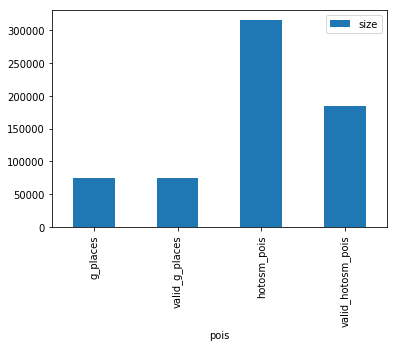

In [4]:
print("ALL saved POIs")
sizes = pd.DataFrame([{"pois": "g_places", "size": len(g_places)},
                      {"pois": "valid_g_places", "size": len(valid_g_places)},
                      {"pois": "hotosm_pois", "size": len(hotosm_pois)}, 
                      {"pois": "valid_hotosm_pois", "size": len(valid_hotosm_pois)}
                      ]).set_index("pois")
print(sizes)
sizes.plot.bar()

In [5]:
request_circles = csv_dao.load_request_circles_df(75)

In [6]:
print("{} circles".format(len(request_circles)))
request_circles.head()

12291 circles


,rc_id,latitude,longitude,radius_m,search_tolerance,sr_ids
0,rc_6189_0,46.45373,6.86650,75,0.0006,"[6189_0, 6189_0, 6189_1, 6175_129, 6175_13, 61..."
1,rc_6189_10,46.51158,6.66102,75,0.0006,"[6189_10, 6189_10, 6177_2512, 6177_2646]"
2,rc_6189_100,46.54204,6.64408,75,0.0006,"[6189_100, 6189_100, 6189_137, 6189_138, 6189_..."
3,rc_6189_101,46.54100,6.64300,75,0.0006,"[6189_101, 6189_101]"
4,rc_6189_102,46.53000,6.65000,75,0.0006,"[6189_102, 6189_102]"


In [9]:
stop_regions = csv_dao.load_all_users_stop_regions_centroids()
stop_regions = csv_dao.unique_stop_regions(stop_regions)
print("{} unique Stop Regions".format(len(stop_regions)))
stop_regions = stop_regions.apply(sr_row_to_stop_region, axis=1)

All Stop Regions:    120607
54520 unique Stop Regions


In [10]:
populate_stop_regions({"hotosm_pois": hotosm_pois, 
                       "valid_hotosm_pois": valid_hotosm_pois,
                       "g_places": g_places,
                       "valid_g_places": valid_g_places}, 
                      stop_regions)

## Stop Regions distance to the closest POIs

#### Total POIs within the Stop Regions radius 75m.

In [11]:
len(google_places.valid_pois_google(g_places)["types"]) / len(g_places["types"])

0.5584776566174898

In [12]:
sizes = []

for sr in stop_regions:
    sizes.append({"sr_id": sr.sr_id, 
                  "len_hot_osm": len(sr.hot_osm),
                  "len_valid_hot_osm": len(sr.valid_hot_osm),
                  "len_g_places": len(sr.g_places),
                  "len_valid_g_places": len(sr.valid_g_places)})

sizes = pd.DataFrame(sizes)
sizes = sizes.set_index("sr_id")

In [13]:
sizes.head()

,len_g_places,len_hot_osm,len_valid_g_places,len_valid_hot_osm
sr_id,,,,
6189_0,3,0,3,0
6189_1,3,0,3,0
6189_10,34,3,34,2
6189_100,0,0,0,0
6189_101,4,0,4,0


GOOGLE PLACES
Size median: 4.0


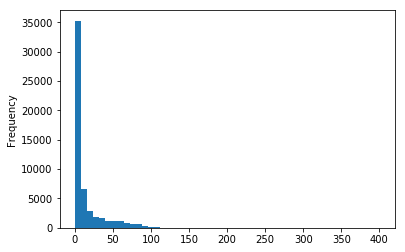

In [14]:
print("google places".upper())
print("Size median: {}".format(sizes["len_g_places"].describe()["50%"]))
sizes["len_g_places"].plot.hist(bins=50, range=(0,400))

HOT OSM
Size median: 1.0


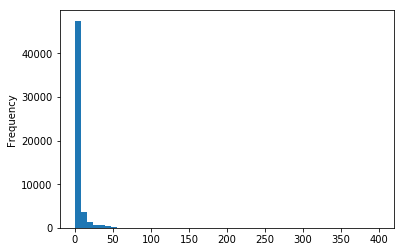

In [15]:
print("hot osm".upper())
print("Size median: {}".format(sizes["len_hot_osm"].describe()["50%"]))
sizes["len_hot_osm"].plot.hist(bins=50, range=(0,400))

VALID GOOGLE PLACES
Size median: 4.0


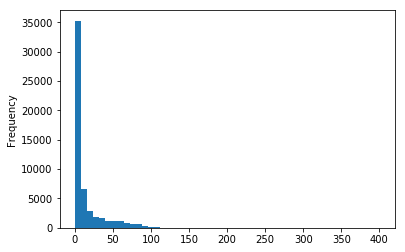

In [16]:
print("valid google places".upper())
print("Size median: {}".format(sizes["len_valid_g_places"].describe()["50%"]))
sizes["len_valid_g_places"].plot.hist(bins=50, range=(0,400))

VALID HOT OSM
Size median: 0.0


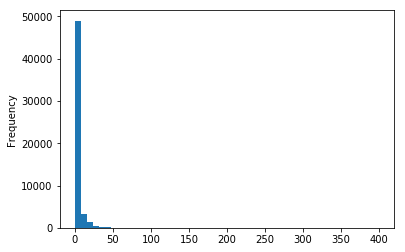

In [17]:
print("valid hot osm".upper())
print("Size median: {}".format(sizes["len_valid_hot_osm"].describe()["50%"]))
sizes["len_valid_hot_osm"].plot.hist(bins=50, range=(0,400))